In [1]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
from numpy.random import choice

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

n_classes = 10 # all examples have 10 classes

sns.set_style('white')
cmap = sns.color_palette('Paired', n_classes)

results_path = Path('results', 'fashion_mnist')
if not results_path.exists():
    results_path.mkdir(parents=True)

Using GPU


In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
class_dict = {0: 'T-shirt/top',
              1: 'Trouser',
              2: 'Pullover',
              3: 'Dress',
              4: 'Coat',
              5: 'Sandal',
              6: 'Shirt',
              7: 'Sneaker',
              8: 'Bag',
              9: 'Ankle boot'}
classes = list(class_dict.keys())

In [5]:
# Reshape & normalize Fashion MNIST data
image_size = 28

def data_prep_conv(x, size=image_size):
    return x.reshape(-1, size, size, 1).astype('float32')/255

X_train_scaled = data_prep_conv(X_train)
X_test_scaled = data_prep_conv(X_test)
X_train_scaled.shape, X_test_scaled.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [6]:
# Combine training steps into function
def train_autoencoder(path, model, x_train=X_train_scaled, x_test=X_test_scaled):
    callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
                 ModelCheckpoint(filepath=path, save_best_only=True, save_weights_only=True)]
    model.fit(x=x_train, y=x_train, epochs=100, validation_split=.1, callbacks=callbacks)
    model.load_weights(path)
    mse = model.evaluate(x=x_test, y=x_test)
    return model, mse

In [7]:
input_ = Input(shape=(28, 28, 1), name='Input_3D')
# encoder 32 -> 16 -> 8
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv_1')(input_)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_1')(x)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv_2')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_2')(x)
x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv_3')(x)
encoded_conv = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_3')(x)
# decoder 8 -> 16 -> 32
x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same',
           name='Decoding_Conv_1')(encoded_conv)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_1')(x)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', name='Decoding_Conv_2')(x)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_2')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name='Decoding_Conv_3')(x)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_3')(x) # to reverse the reduction of the filter sizes
decoded_conv = Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same',
                      name='Decoding_Conv_4')(x)

autoencoder_conv = Model(input_, decoded_conv)
autoencoder_conv.compile(optimizer='adam', loss='mse')

autoencoder_conv.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_3D (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 Encoding_Conv_1 (Conv2D)    (None, 28, 28, 32)        320       
                                                                 
 Encoding_Max_1 (MaxPooling2  (None, 14, 14, 32)       0         
 D)                                                              
                                                                 
 Encoding_Conv_2 (Conv2D)    (None, 14, 14, 16)        4624      
                                                                 
 Encoding_Max_2 (MaxPooling2  (None, 7, 7, 16)         0         
 D)                                                              
                                                                 
 Encoding_Conv_3 (Conv2D)    (None, 7, 7, 8)           1160  

In [8]:
path = (results_path / 'autencoder_conv.32.weights.hdf5').as_posix()

In [9]:
autoencoder_deep, mse = train_autoencoder(path, autoencoder_conv, x_train=X_train_scaled, x_test=X_test_scaled)

Epoch 1/100
1688/1688 [==============================] - 16s 6ms/step - loss: 0.0227 - val_loss: 0.0173
Epoch 2/100
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0159 - val_loss: 0.0150
Epoch 3/100
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 4/100
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0135 - val_loss: 0.0131
Epoch 5/100
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0129 - val_loss: 0.0128
Epoch 6/100
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0125 - val_loss: 0.0122
Epoch 7/100
1688/1688 [==============================] - 9s 6ms/step - loss: 0.0121 - val_loss: 0.0126
Epoch 8/100
1688/1688 [==============================] - 9s 6ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 9/100
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 10/100
1688/1688 [==============================] - 9s 5ms/step - 

In [10]:
print(f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}')

autoencoder_conv.load_weights(path)
reconstructed_images = autoencoder_deep.predict(X_test_scaled)
reconstructed_images.shape
# deep autoencoder - MSE: 0.0097 | RMSE 0.0987(AE_DeepAutoEncoders.ipynb)
# convolutional autoencoders - MSE: 0.0090(7.8% improved) | RMSE 0.0951(3.78% improved)

MSE: 0.0090 | RMSE 0.0951


(10000, 28, 28, 1)

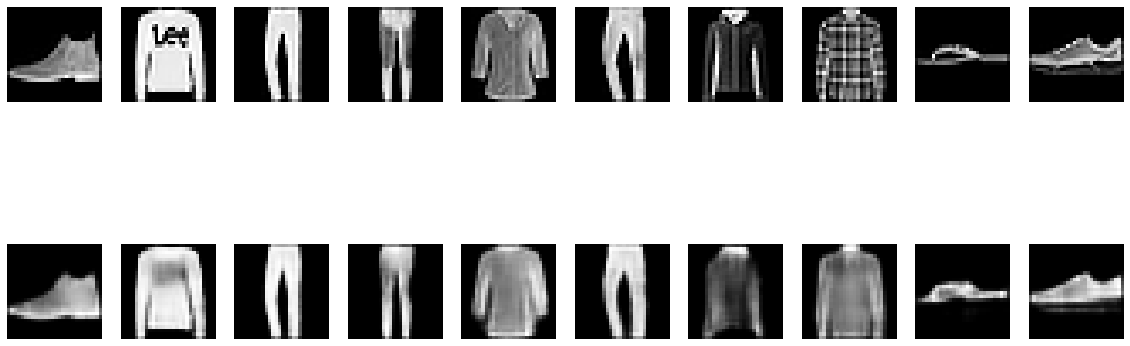

In [11]:
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 8))
for i in range(n_classes):
    axes[0, i].imshow(X_test_scaled[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_images[i].reshape(image_size, image_size) , cmap='gray')
    axes[1, i].axis('off')

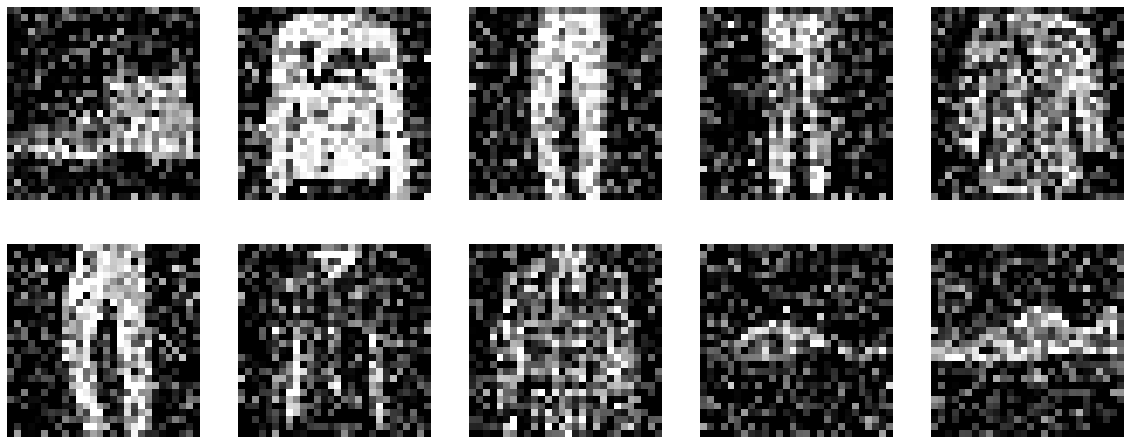

In [12]:
# Denoising Autoencoder to get uncorrupted originals
def add_noise(x, noise_factor=.3):
    return np.clip(x  + noise_factor * np.random.normal(size=x.shape), 0, 1)

X_train_noisy = add_noise(X_train_scaled)
X_test_noisy = add_noise(X_test_scaled)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

In [13]:
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv_1')(input_)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_1')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv_2')(x)
encoded_conv = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_3')(x)

x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Decoding_Conv_1')(encoded_conv)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_1')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Decoding_Conv_2')(x)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_2')(x)
decoded_conv = Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same', name='Decoding_Conv_4')(x)
autoencoder_denoise = Model(input_, decoded_conv)
autoencoder_denoise.compile(optimizer='adam', loss='mse')
path = (results_path / 'autencoder_denoise.32.weights.hdf5').as_posix()

In [14]:
callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
             ModelCheckpoint(filepath=path, save_best_only=True, save_weights_only=True)]
autoencoder_denoise.fit(x=X_train_noisy, y=X_train_scaled, epochs=100, batch_size=128, shuffle=True,
                        validation_split=.1, callbacks=callbacks)

Epoch 1/100
422/422 [==============================] - 4s 7ms/step - loss: 0.0227 - val_loss: 0.0149
Epoch 2/100
422/422 [==============================] - 3s 6ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 3/100
422/422 [==============================] - 3s 6ms/step - loss: 0.0125 - val_loss: 0.0119
Epoch 4/100
422/422 [==============================] - 3s 6ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 5/100
422/422 [==============================] - 3s 6ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 6/100
422/422 [==============================] - 3s 6ms/step - loss: 0.0105 - val_loss: 0.0104
Epoch 7/100
422/422 [==============================] - 3s 6ms/step - loss: 0.0102 - val_loss: 0.0101
Epoch 8/100
422/422 [==============================] - 3s 6ms/step - loss: 0.0100 - val_loss: 0.0099
Epoch 9/100
422/422 [==============================] - 3s 6ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 10/100
422/422 [==============================] - 3s 6ms/step - loss: 0.0097 - val_lo

In [15]:
autoencoder_denoise.load_weights(path)
mse = autoencoder_denoise.evaluate(x=X_test_noisy, y=X_test_scaled)
print(f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}')

313/313 [==============================] - 1s 2ms/step - loss: 0.0085
MSE: 0.0085 | RMSE 0.0922


In [16]:
# Visualize Reconstructed Images
reconstructed_images = autoencoder_denoise.predict(X_test_noisy)
reconstructed_images.shape

(10000, 28, 28, 1)

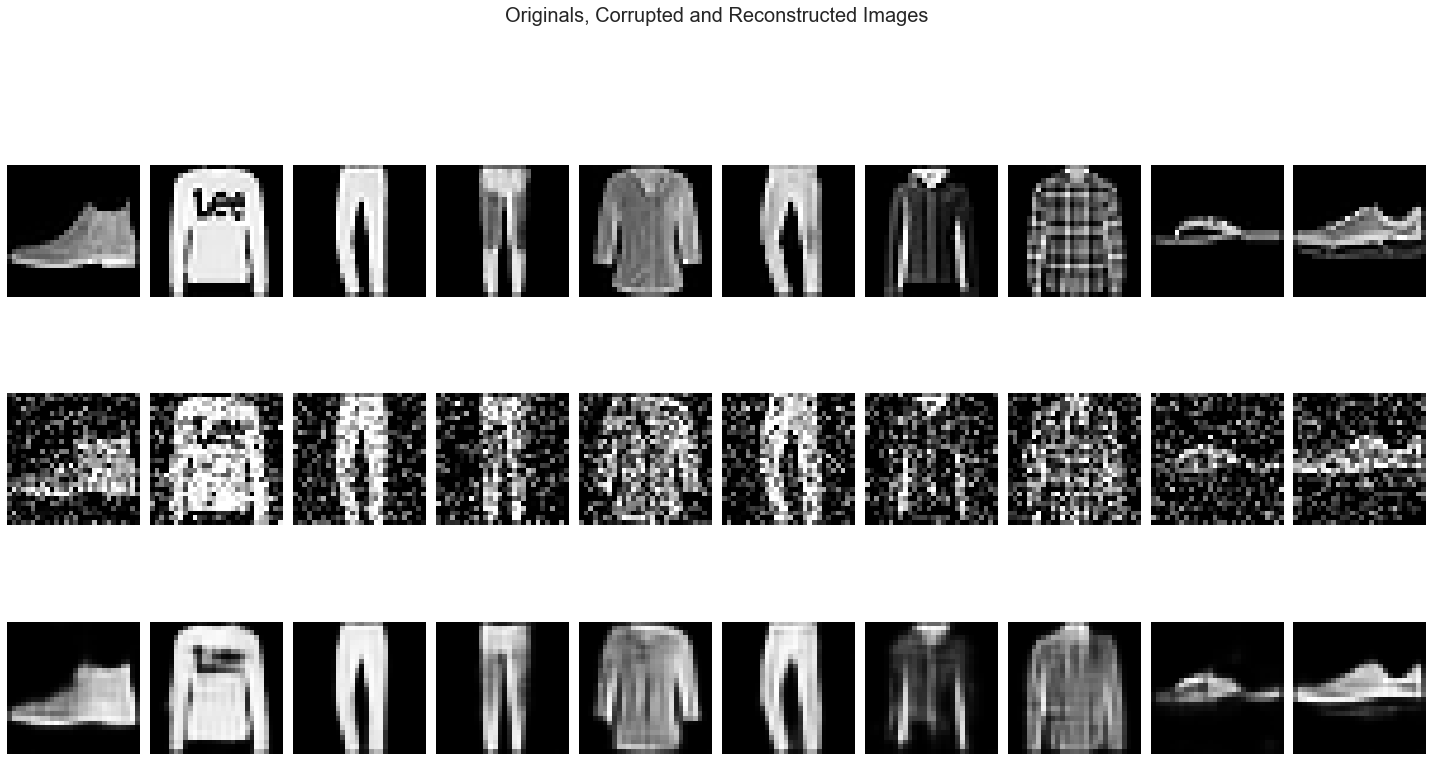

In [17]:
fig, axes = plt.subplots(ncols=n_classes, nrows=3, figsize=(20, 12))
for i in range(n_classes):
    axes[0, i].imshow(X_test[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(X_test_noisy[i].reshape(image_size, image_size), cmap='gray')
    axes[1, i].axis('off')

    axes[2, i].imshow(reconstructed_images[i].reshape(image_size, image_size) , cmap='gray')
    axes[2, i].axis('off')

fig.suptitle('Originals, Corrupted and Reconstructed Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'autoencoder_denoising', dpi=300)